In [ ]:
# the keys in this document do not work anymore

# Classification using Groq

In [1]:
# trying with groq

import os
import time
import base64
import pandas as pd
from groq import Groq
from PIL import Image
from io import BytesIO

GROQ_KEY = "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"

# Classes to classify into
class_list = [
    'baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man',
    'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail',
    'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman',
    'worm'
]

# Helper function to convert image to base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

def classify_image_with_retry(base64_image, prompt, retries=3):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}",
                                },
                            },
                        ],
                    }
                ],
                model="meta-llama/llama-4-scout-17b-16e-instruct",
            )
            return response.choices[0].message.content.strip()
        
        except Exception as e:
            if "rate_limit_exceeded" in str(e):
                print(f"Rate limit reached. Waiting 90 seconds before retrying...")
                time.sleep(120 * attempt + 90)
            else:
                print(f"Unexpected error: {e}")
                break
    return None


# Initialize Groq client
client = Groq(api_key=GROQ_KEY)

root_dir = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/test/"
results = []
i = 0
MAX_IMAGES_PER_CLASS = 100

for cls in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_folder):
        continue

    images = os.listdir(class_folder)[:MAX_IMAGES_PER_CLASS]
    for img_name in images:
        img_path = os.path.join(class_folder, img_name)
        try:
            base64_image = encode_image(img_path)

            prompt = (
                f"This image belongs to one of the following classes:\n\n"
                f"{', '.join(class_list)}.\n\n"
                f"Please classify it by returning only the most appropriate class name from the list."
            )

            pred = classify_image_with_retry(base64_image, prompt)
            if pred:
                results.append({
                    "real_class": class_name,
                    "predicted_class": pred,
                    "image": img_name
                })

            i += 1
            print(f"{i}. Real: {class_name}, pred: {pred}")

        except Exception as e:
            print(f"Error with {img_path}: {e}")

# Convert results to DataFrame
df = pd.DataFrame(results)
df.to_csv("groq_classification_results.csv", index=False)

print("Classification completed. Results saved to groq_classification_results.csv")


1. Real: man, pred: man
2. Real: man, pred: man
3. Real: man, pred: man
4. Real: man, pred: man
5. Real: man, pred: man
6. Real: man, pred: man
7. Real: man, pred: man
8. Real: man, pred: man
9. Real: man, pred: man
10. Real: man, pred: man
11. Real: man, pred: man
12. Real: man, pred: man
13. Real: man, pred: man
14. Real: man, pred: woman
15. Real: man, pred: man
16. Real: man, pred: man
17. Real: man, pred: man
18. Real: man, pred: man
19. Real: man, pred: man
20. Real: man, pred: man
21. Real: man, pred: woman
22. Real: man, pred: man
23. Real: man, pred: man
24. Real: man, pred: man
25. Real: man, pred: man
26. Real: man, pred: man
27. Real: man, pred: man
28. Real: man, pred: man
29. Real: man, pred: woman
30. Real: man, pred: man
31. Real: man, pred: man
32. Real: man, pred: man
33. Real: man, pred: man
34. Real: man, pred: man
35. Real: man, pred: man
36. Real: man, pred: woman
37. Real: man, pred: man
38. Real: man, pred: man
39. Real: man, pred: woman
40. Real: man, pred: man

In [2]:
df

,real_class,predicted_class,image
0,man,man,adam_s_002297.png
1,man,man,man_s_000089.png
2,man,man,adam_s_002095.png
3,man,man,abel_s_000720.png
4,man,man,abel_s_000091.png
...,...,...,...
1763,woman,woman,white_woman_s_001339.png
1764,woman,woman,black_woman_s_000196.png
1765,woman,woman,white_woman_s_000580.png
1766,woman,woman,black_woman_s_000627.png


In [6]:
import re

def clean_prediction_with_regex(text, class_names):
    text = text.lower()
    for cls in class_names:
        pattern = r'\b' + re.escape(cls.lower()) + r'\b'
        if re.search(pattern, text):
            return cls
    return "unknown"

df['cleaned_predicted_class'] = df['predicted_class'].apply(
    lambda x: clean_prediction_with_regex(x, class_list)
)

In [7]:
df

,real_class,predicted_class,image,cleaned_predicted_class
0,man,man,adam_s_002297.png,man
1,man,man,man_s_000089.png,man
2,man,man,adam_s_002095.png,man
3,man,man,abel_s_000720.png,man
4,man,man,abel_s_000091.png,man
...,...,...,...,...
1763,woman,woman,white_woman_s_001339.png,woman
1764,woman,woman,black_woman_s_000196.png,woman
1765,woman,woman,white_woman_s_000580.png,woman
1766,woman,woman,black_woman_s_000627.png,woman


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Function to show the confussion matrix
def show_pred_cm(reals, preds, title="Confusion Matrix"):
    class_list = list(set(reals))
    cm = confusion_matrix(reals, preds, labels=class_list)
    cm_df = pd.DataFrame(cm, index=class_list, columns=class_list)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


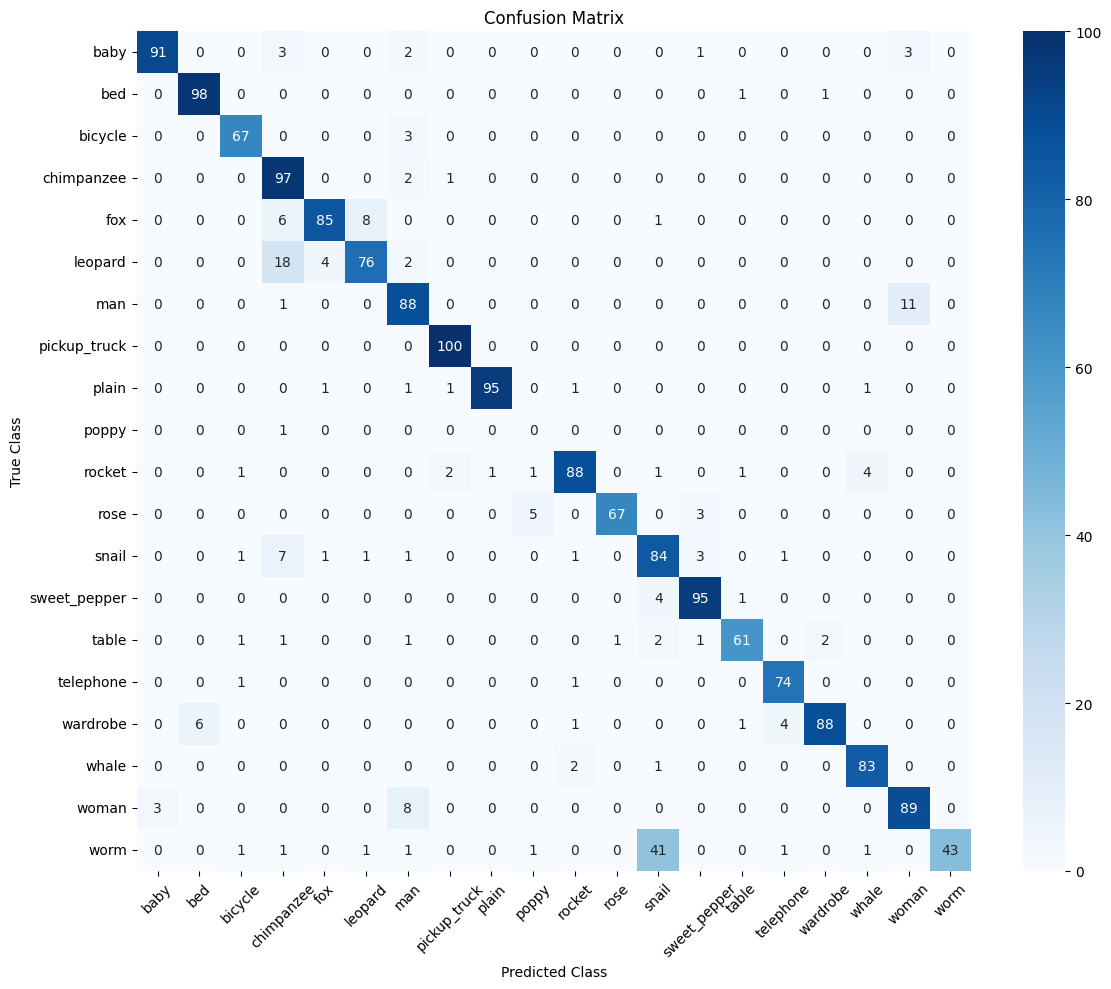

In [16]:
show_pred_cm(df['real_class'], df['cleaned_predicted_class'], title="Confusion Matrix using Groq")

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, cohen_kappa_score, \
    matthews_corrcoef, roc_auc_score, balanced_accuracy_score, classification_report

# Function to compute metrics and return a dictionary of results
def compute_metrics(y_true, y_pred, verbose=True):
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)

    # Balanced Accuracy
    metrics['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['F1-Score'] = f1
    
    # Cohen’s Kappa
    metrics['Cohens Kappa'] = cohen_kappa_score(y_true, y_pred)
    
    # Matthews Correlation Coefficient (MCC)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    
    # ROC-AUC Score (for multi-class problems, use 'ovr' method)
    #metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted', labels=np.unique(y_true))

    if verbose:
        print(f"Accuracy: {metrics['Accuracy']}")
        print(f"Balanced Accuracy: {metrics['Balanced Accuracy']}")
        print(f"Precision: {metrics['Precision']}")
        print(f"Recall: {metrics['Recall']}")
        print(f"F1-Score: {metrics['F1-Score']}")
        print(f"Cohens Kappa: {metrics['Cohens Kappa']}")
        print(f"MCC: {metrics['MCC']}")
    
    # Classification Report
    class_report = classification_report(y_true, y_pred, output_dict=True)
    metrics['Classification Report'] = class_report

    if verbose:
        print(classification_report(y_true, y_pred))
    
    return metrics

In [28]:
compute_metrics(df['real_class'], df['cleaned_predicted_class'])

Accuracy: 0.8874434389140271
Balanced Accuracy: 0.8441060806458603
Precision: 0.9035395570238394
Recall: 0.8874434389140271
F1-Score: 0.8877490374728153
Cohens Kappa: 0.8811046596110942
MCC: 0.881908195284213
              precision    recall  f1-score   support

        baby       0.97      0.91      0.94       100
         bed       0.94      0.98      0.96       100
     bicycle       0.93      0.96      0.94        70
  chimpanzee       0.72      0.97      0.83       100
         fox       0.93      0.85      0.89       100
     leopard       0.88      0.76      0.82       100
         man       0.81      0.88      0.84       100
pickup_truck       0.96      1.00      0.98       100
       plain       0.99      0.95      0.97       100
       poppy       0.00      0.00      0.00         1
      rocket       0.94      0.89      0.91        99
        rose       0.99      0.89      0.94        75
       snail       0.63      0.84      0.72       100
sweet_pepper       0.92      0.95 

{'Accuracy': 0.8874434389140271,
 'Balanced Accuracy': np.float64(0.8441060806458603),
 'Precision': 0.9035395570238394,
 'Recall': 0.8874434389140271,
 'F1-Score': 0.8877490374728153,
 'Cohens Kappa': np.float64(0.8811046596110942),
 'MCC': np.float64(0.881908195284213),
 'Classification Report': {'baby': {'precision': 0.9680851063829787,
   'recall': 0.91,
   'f1-score': 0.9381443298969072,
   'support': 100.0},
  'bed': {'precision': 0.9423076923076923,
   'recall': 0.98,
   'f1-score': 0.9607843137254902,
   'support': 100.0},
  'bicycle': {'precision': 0.9305555555555556,
   'recall': 0.9571428571428572,
   'f1-score': 0.9436619718309859,
   'support': 70.0},
  'chimpanzee': {'precision': 0.7185185185185186,
   'recall': 0.97,
   'f1-score': 0.825531914893617,
   'support': 100.0},
  'fox': {'precision': 0.9340659340659341,
   'recall': 0.85,
   'f1-score': 0.8900523560209425,
   'support': 100.0},
  'leopard': {'precision': 0.8837209302325582,
   'recall': 0.76,
   'f1-score': 0.

In [ ]:
# ojo que esto puede tener overfitting

# Get descriptions from images

In [8]:
import os
import base64
import random
from groq import Groq
from PIL import Image
from io import BytesIO

GROQ_KEY = "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"
dataset = "test"
base_path = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/" + dataset
class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

client = Groq(api_key=GROQ_KEY)

# Helper: encode image to base64
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Dictionary to hold descriptions
class_descriptions = {}

for cls in class_names:
    class_folder = os.path.join(base_path, cls)
    image_files = [f for f in os.listdir(class_folder) if f.endswith(".png")]
    selected_images = random.sample(image_files, min(5, len(image_files)))

    image_inputs = []
    for img_name in selected_images:
        image_path = os.path.join(class_folder, img_name)
        encoded = encode_image(image_path)
        image_inputs.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded}"
            }
        })

    # Build the prompt
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"These 5 images are examples from the class '{cls}'. Based on these images, give a detailed visual description that summarizes the typical appearance of this class. Briefness is required, using only one paragraph"}
            ] + image_inputs
        }
    ]

    try:
        response = client.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=messages,
        )
        description = response.choices[0].message.content.strip()
        class_descriptions[cls] = description
        print(f"✔️ {cls}: Description generated.")
    except Exception as e:
        print(f"❌ Error with class {cls}: {e}")
        class_descriptions[cls] = None

# Optional: Save results to JSON
import json
with open("class_descriptions.json", "w") as f:
    json.dump(class_descriptions, f, indent=2)

# Print results
for cls, desc in class_descriptions.items():
    print(f"\n🔹 {cls.upper()}:\n{desc}\n")


✔️ baby: Description generated.
✔️ bed: Description generated.
✔️ bicycle: Description generated.
✔️ chimpanzee: Description generated.
✔️ fox: Description generated.
✔️ leopard: Description generated.
✔️ man: Description generated.
✔️ pickup_truck: Description generated.
✔️ plain: Description generated.
✔️ poppy: Description generated.
✔️ rocket: Description generated.
✔️ rose: Description generated.
✔️ snail: Description generated.
✔️ sweet_pepper: Description generated.
✔️ table: Description generated.
✔️ telephone: Description generated.
✔️ wardrobe: Description generated.
✔️ whale: Description generated.
✔️ woman: Description generated.
✔️ worm: Description generated.

🔹 BABY:
The typical appearance of a baby includes a chubby, rounded face, soft features, and a small nose and mouth. They have large eyes and sparse or no hair on their head. Their skin is smooth and often rosy. The babies are dressed in casual clothing like onesies, pants, and light jackets, sitting or being held. 

In [ ]:
# limpiar el promt para que no diga cosas de la imagen

In [21]:
# Extracting entities

import os
import base64
import random
import json
from groq import Groq

GROQ_KEY = "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"
dataset = "test"
base_path = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/" + dataset
class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

client = Groq(api_key=GROQ_KEY)

# Helper: encode image to base64
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Dictionary to store results
visual_entities_by_class = {}

for cls in class_names:
    class_folder = os.path.join(base_path, cls)
    image_files = [f for f in os.listdir(class_folder) if f.endswith(".png")]
    selected_images = random.sample(image_files, min(5, len(image_files)))

    image_inputs = []
    for img_name in selected_images:
        img_path = os.path.join(class_folder, img_name)
        encoded = encode_image(img_path)
        image_inputs.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded}"
            }
        })

    prompt = (
        f"These 5 images are examples of the class '{cls}'. "
        "Based on these images, return exactly 10 distinct visual entities or features that are most representative of this class. "
        "Return ONLY the list. No introduction, no explanation, just 10 visual terms in bullet points or comma-separated."
    )

    try:
        response = client.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[
                {
                    "role": "user",
                    "content": [{"type": "text", "text": prompt}] + image_inputs,
                }
            ],
        )
        content = response.choices[0].message.content.strip()
        
        #  clean and split into list of 10 entities
        entities = [e.strip("•*- ") for e in content.replace("\n", ",").split(",") if e.strip()]
        entities = entities[:10]  # Ensure exactly 10
        visual_entities_by_class[cls] = entities

        print(f"✔️ {cls}: {entities}")

    except Exception as e:
        print(f"❌ Error with class {cls}: {e}")
        visual_entities_by_class[cls] = None

# Optional: Save to JSON
with open("visual_entities_by_class.json", "w") as f:
    json.dump(visual_entities_by_class, f, indent=2)

# Display result
for cls, ents in visual_entities_by_class.items():
    print(f"\n🔹 {cls.upper()}:\n{ents}\n")


✔️ baby: ['chubby cheeks', 'round face', 'large eyes', 'small nose', 'open mouth', 'tiny hands', 'soft skin', 'baby clothes', 'headband', 'pacifier.']
✔️ bed: ['Mattress', 'Frame', 'Pillow', 'Sheets', 'Bunk', 'Ladder', 'Headboard', 'Footboard', 'Rails', 'Bedding']
✔️ bicycle: ['wheels', 'frame', 'pedals', 'seat', 'handlebars', 'chain', 'spokes', 'tires', 'gears', 'fork']
✔️ chimpanzee: ['Fur', 'Dark coloration', 'Large nose', 'Wide forehead', 'Thick eyebrows', 'Prominent jaw', 'Dark eyes', 'Hair on face', 'Muscular build', 'Hands']
✔️ fox: ['orange fur', 'pointed ears', 'bushy tail', 'white muzzle', 'black nose', 'sharp eyes', 'reddish color', 'white chest', 'thin legs', 'alert posture']
✔️ leopard: ['spots', 'fur', 'ears', 'whiskers', 'nose', 'eyes', 'spots pattern', 'paws', 'tail', 'mouth']
✔️ man: ['short hair', 'facial hair', 'hat', 'mustache', 'jacket', 'tie', 'shirt', 'short beard', 'sweater', 'collar']
✔️ pickup_truck: ['Open cargo bed', 'Large front grille', 'Four wheel tires',

In [ ]:
# Select the best definition or each word

In [23]:
# Use wordnet for small definition
import nltk
from nltk.corpus import wordnet as wn
from transformers import pipeline

def get_wordnet_definitions(class_name):
    synsets = wn.synsets(class_name)
    if synsets:
        return [acepcion.definition() for acepcion in synsets]
    return None

In [25]:
get_wordnet_definitions('baby')

['a very young child (birth to 1 year) who has not yet begun to walk or talk',
 'the youngest member of a group (not necessarily young)',
 'an immature childish person',
 'an unborn child; a human fetus',
 '(slang) sometimes used as a term of address for attractive young women',
 'a very young mammal',
 'a project of personal concern to someone',
 'treat with excessive indulgence']

In [37]:
# Parameters
NUM_IMAGES = 5
dataset = "test"

base_path = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/" + dataset
class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

# Final results
best_description = {}

# Process each class
for cls in class_names:
    class_folder = os.path.join(base_path, cls)
    image_files = [f for f in os.listdir(class_folder) if f.endswith(".png")]
    selected_images = random.sample(image_files, min(5, len(image_files)))

    # Extract possible descriptions
    descriptions = get_wordnet_definitions(cls)

    # Image content
    image_messages = []
    for img_name in selected_images:
        img_path = os.path.join(class_folder, img_name)
        encoded = encode_image(img_path)
        image_messages.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
            },
        })

    # Add text prompt
    image_messages.insert(0, {
        "type": "text",
        "text": (
            f"Here are several images from the class '{cls}'. "
            f"Given the following descriptions:\n\n" +
            "\n".join(descriptions) +
            "\n\nWhich description best matches the visual characteristics shown in these images? "
            "Reply with the exact description."
        )
    })

    # Send to Groq
    try:
        response = client.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[{"role": "user", "content": image_messages}]
        )
        reply = response.choices[0].message.content.strip()
        best_description[cls] = reply
        print(f"{cls}: {reply}")

    except Exception as e:
        print(f"Error processing class {cls}: {e}")

# Result
print("\nBest descriptions:")
for cls, desc in best_description.items():
    print(f"{cls}: {desc}")


baby: (slang) sometimes used as a term of address for attractive young women
bed: a piece of furniture that provides a place to sleep
bicycle: a wheeled vehicle that has two wheels and is moved by foot pedals
chimpanzee: intelligent somewhat arboreal ape of equatorial African forests
fox: be confusing or perplexing to; cause to be unable to think clearly
leopard: the pelt of a leopard
man: the generic use of the word to refer to any human being
pickup_truck: None of the provided images show a pickup truck. However, based on the given descriptions and assuming the task is to identify the description that could hypothetically match a 'pickup_truck' class if an image of one were provided:

a light truck with an open body and low sides and a tailboard

This description directly corresponds with common visual characteristics of a pickup truck. Therefore, the description that best matches is:

a light truck with an open body and low sides and a tailboard
plain: unmistakably (`plain' is often

In [38]:
# this descriptions are horrible

In [ ]:
# yo creo que me saltaria directamente el wordnet

In [1]:
import os
import random
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import open_clip
from sklearn.metrics.pairwise import cosine_similarity

# Settings
DATASET_DIR = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/test/"
CLASSES = ['baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man',
           'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail',
           'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman',
           'worm']
IMAGES_PER_CLASS = 50

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

# Load CLIP
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model = model.to(DEVICE).eval()

# Encode class names
with torch.no_grad():
    class_tokens = tokenizer(CLASSES).to(DEVICE)
    class_embeddings = model.encode_text(class_tokens)
    class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)

# Collect image paths
all_image_paths = []
for class_name in CLASSES:
    folder = os.path.join(DATASET_DIR, class_name)
    all_images = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.endswith(('.jpg', '.png'))]
    sampled = random.sample(all_images, min(IMAGES_PER_CLASS, len(all_images)))
    for img_path in sampled:
        all_image_paths.append((img_path, class_name))

# Encode images and classify
results = []
for img_path, true_class in tqdm(all_image_paths, desc="Classifying images"):
    image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        image_embedding = model.encode_image(image)
        image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)

        similarities = cosine_similarity(image_embedding.cpu().numpy(), class_embeddings.cpu().numpy())
        pred_idx = similarities.argmax()
        pred_class = CLASSES[pred_idx]

    results.append({
        "image_path": img_path,
        "real_class": true_class,
        "predicted_class": pred_class
    })

# Create DataFrame
df_clip = pd.DataFrame(results)


/Users/jdieguez/anaconda3/envs/tfm2/lib/python3.9/site-packages/open_clip/transformer.py:851: UserWarning: MPS: no support for int64 for argmax_argmin_out, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:837.)
  pooled = x[torch.arange(x.shape[0]), text.argmax(dim=-1)]
Classifying images: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.91it/s]


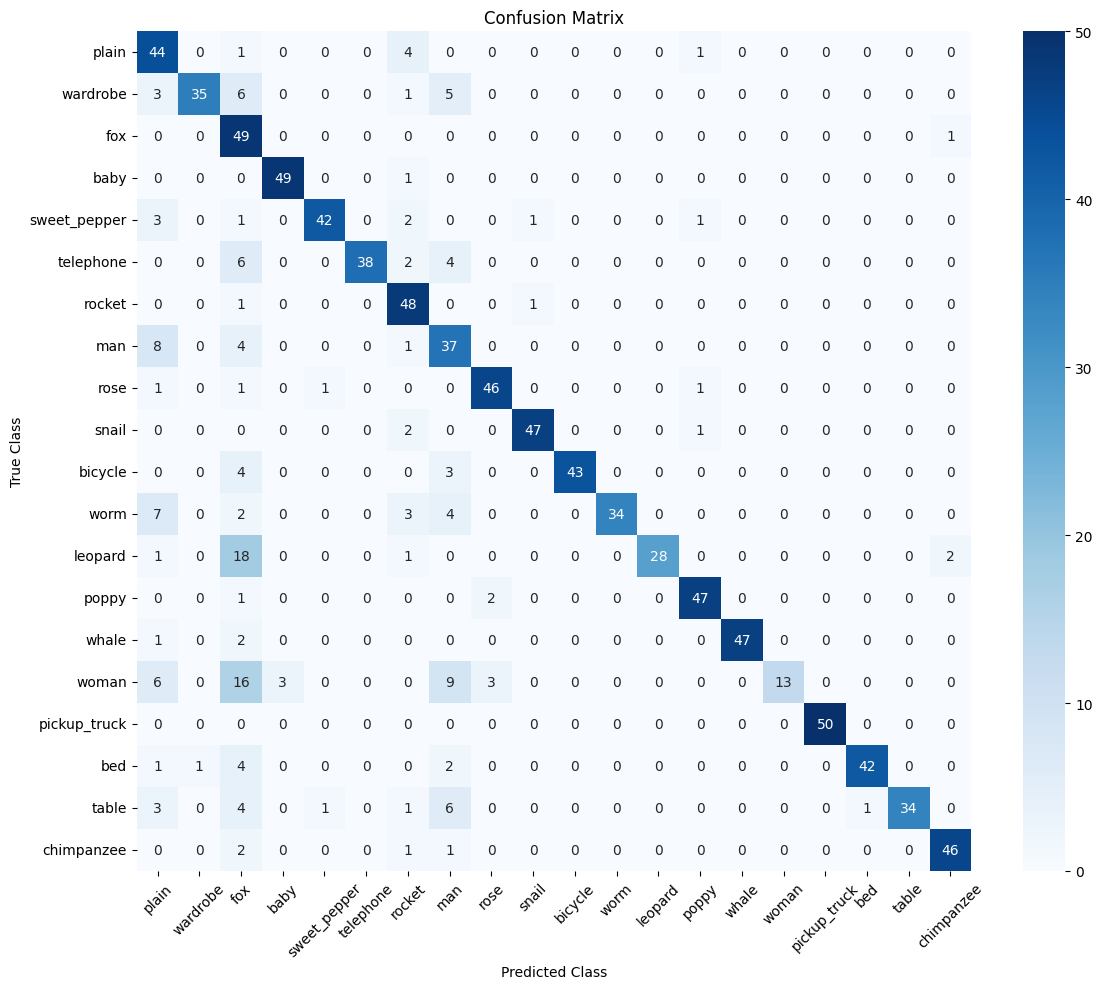

Accuracy: 0.819
Balanced Accuracy: 0.819
Precision: 0.8885297364968028
Recall: 0.819
F1-Score: 0.8244218819205973
Cohens Kappa: 0.8094736842105263
MCC: 0.8135750196446988
              precision    recall  f1-score   support

        baby       0.94      0.98      0.96        50
         bed       0.98      0.84      0.90        50
     bicycle       1.00      0.86      0.92        50
  chimpanzee       0.94      0.92      0.93        50
         fox       0.40      0.98      0.57        50
     leopard       1.00      0.56      0.72        50
         man       0.52      0.74      0.61        50
pickup_truck       1.00      1.00      1.00        50
       plain       0.56      0.88      0.69        50
       poppy       0.92      0.94      0.93        50
      rocket       0.72      0.96      0.82        50
        rose       0.90      0.92      0.91        50
       snail       0.96      0.94      0.95        50
sweet_pepper       0.95      0.84      0.89        50
       table      

{'Accuracy': 0.819,
 'Balanced Accuracy': 0.819,
 'Precision': 0.8885297364968028,
 'Recall': 0.819,
 'F1-Score': 0.8244218819205973,
 'Cohens Kappa': 0.8094736842105263,
 'MCC': 0.8135750196446988,
 'Classification Report': {'baby': {'precision': 0.9423076923076923,
   'recall': 0.98,
   'f1-score': 0.9607843137254902,
   'support': 50.0},
  'bed': {'precision': 0.9767441860465116,
   'recall': 0.84,
   'f1-score': 0.9032258064516129,
   'support': 50.0},
  'bicycle': {'precision': 1.0,
   'recall': 0.86,
   'f1-score': 0.9247311827956989,
   'support': 50.0},
  'chimpanzee': {'precision': 0.9387755102040817,
   'recall': 0.92,
   'f1-score': 0.9292929292929293,
   'support': 50.0},
  'fox': {'precision': 0.4016393442622951,
   'recall': 0.98,
   'f1-score': 0.5697674418604651,
   'support': 50.0},
  'leopard': {'precision': 1.0,
   'recall': 0.56,
   'f1-score': 0.717948717948718,
   'support': 50.0},
  'man': {'precision': 0.5211267605633803,
   'recall': 0.74,
   'f1-score': 0.6115

In [7]:
show_pred_cm(df_clip['real_class'], df_clip['predicted_class'], title="Confusion Matrix with CLIP")
compute_metrics(df_clip['real_class'], df_clip['predicted_class'])

In [11]:
import os
import random
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import open_clip
from sklearn.metrics.pairwise import cosine_similarity

# Settings
DATASET_DIR = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/test/"
CLASSES = ['baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man',
           'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail',
           'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman',
           'worm']
IMAGES_PER_CLASS = 100

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

# Load CLIP
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model = model.to(DEVICE).eval()

# Encode the descriptions
class_names = list(class_descriptions.keys())
text_descriptions = list(class_descriptions.values())
with torch.no_grad():
    text_tokens = tokenizer(text_descriptions).to(DEVICE)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Collect image paths
all_image_paths = []
for class_name in CLASSES:
    folder = os.path.join(DATASET_DIR, class_name)
    all_images = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.endswith(('.jpg', '.png'))]
    sampled = random.sample(all_images, min(IMAGES_PER_CLASS, len(all_images)))
    for img_path in sampled:
        all_image_paths.append((img_path, class_name))

# Encode images and classify
results = []
for img_path, true_class in tqdm(all_image_paths, desc="Classifying images"):
    image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        image_embedding = model.encode_image(image)
        image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)

        similarities = cosine_similarity(image_embedding.cpu().numpy(), text_features.cpu().numpy())
        pred_idx = similarities.argmax()
        pred_class = CLASSES[pred_idx]

    results.append({
        "image_path": img_path,
        "real_class": true_class,
        "predicted_class": pred_class
    })

# Create DataFrame
df_clip_2 = pd.DataFrame(results)


Classifying images: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.40it/s]


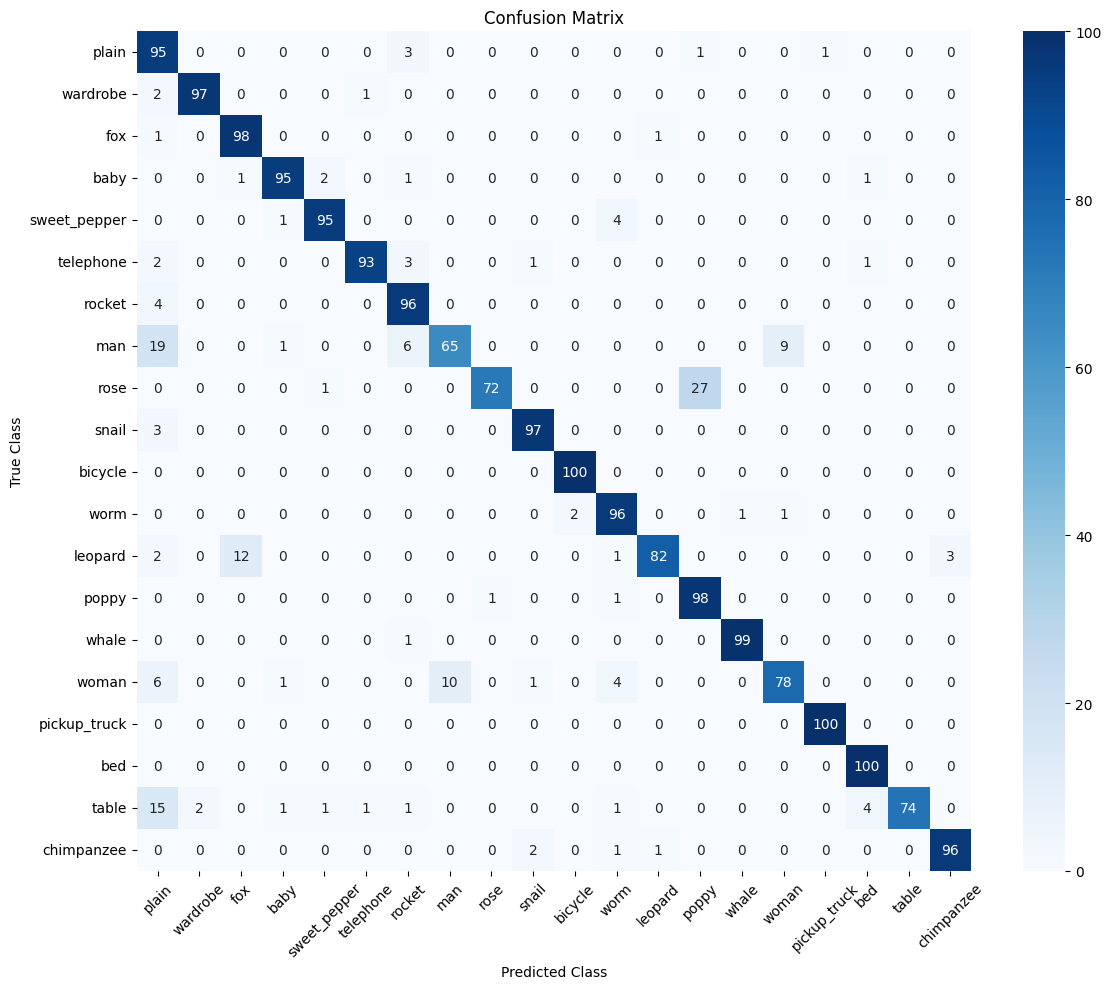

Accuracy: 0.913
Balanced Accuracy: 0.913
Precision: 0.9239719063003184
Recall: 0.913
F1-Score: 0.9126702947086959
Cohens Kappa: 0.9084210526315789
MCC: 0.9091251795922058
              precision    recall  f1-score   support

        baby       0.96      0.95      0.95       100
         bed       0.94      1.00      0.97       100
     bicycle       0.98      1.00      0.99       100
  chimpanzee       0.97      0.96      0.96       100
         fox       0.88      0.98      0.93       100
     leopard       0.98      0.82      0.89       100
         man       0.87      0.65      0.74       100
pickup_truck       0.99      1.00      1.00       100
       plain       0.64      0.95      0.76       100
       poppy       0.78      0.98      0.87       100
      rocket       0.86      0.96      0.91       100
        rose       0.99      0.72      0.83       100
       snail       0.96      0.97      0.97       100
sweet_pepper       0.96      0.95      0.95       100
       table      

{'Accuracy': 0.913,
 'Balanced Accuracy': 0.913,
 'Precision': 0.9239719063003184,
 'Recall': 0.913,
 'F1-Score': 0.9126702947086959,
 'Cohens Kappa': 0.9084210526315789,
 'MCC': 0.9091251795922058,
 'Classification Report': {'baby': {'precision': 0.9595959595959596,
   'recall': 0.95,
   'f1-score': 0.9547738693467337,
   'support': 100.0},
  'bed': {'precision': 0.9433962264150944,
   'recall': 1.0,
   'f1-score': 0.970873786407767,
   'support': 100.0},
  'bicycle': {'precision': 0.9803921568627451,
   'recall': 1.0,
   'f1-score': 0.9900990099009901,
   'support': 100.0},
  'chimpanzee': {'precision': 0.9696969696969697,
   'recall': 0.96,
   'f1-score': 0.964824120603015,
   'support': 100.0},
  'fox': {'precision': 0.8828828828828829,
   'recall': 0.98,
   'f1-score': 0.9289099526066351,
   'support': 100.0},
  'leopard': {'precision': 0.9761904761904762,
   'recall': 0.82,
   'f1-score': 0.8913043478260869,
   'support': 100.0},
  'man': {'precision': 0.8666666666666667,
   'rec

In [12]:
show_pred_cm(df_clip_2['real_class'], df_clip_2['predicted_class'], title="Confusion Matrix with CLIP")
compute_metrics(df_clip_2['real_class'], df_clip_2['predicted_class'])

In [13]:
# Get descriptions for all classes with groq

import os
import base64
import random
from groq import Groq
from PIL import Image
from io import BytesIO

GROQ_KEY = "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"
# Dictionary to hold descriptions
class_descriptions = {}

for dataset in ["train", "val", "test"]:

    base_path = "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/" + dataset
    class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    
    client = Groq(api_key=GROQ_KEY)
    
    # Helper: encode image to base64
    def encode_image(image_path):
        with open(image_path, "rb") as f:
            return base64.b64encode(f.read()).decode("utf-8")
    
    for cls in class_names:
        class_folder = os.path.join(base_path, cls)
        image_files = [f for f in os.listdir(class_folder) if f.endswith(".png")]
        selected_images = random.sample(image_files, min(5, len(image_files)))
    
        image_inputs = []
        for img_name in selected_images:
            image_path = os.path.join(class_folder, img_name)
            encoded = encode_image(image_path)
            image_inputs.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded}"
                }
            })
    
        # Build the prompt
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"These 5 images are examples from the class '{cls}'. Based on these images, give a detailed visual description that summarizes the typical appearance of this class. Briefness is required, using only one paragraph"}
                ] + image_inputs
            }
        ]
    
        try:
            response = client.chat.completions.create(
                model="meta-llama/llama-4-scout-17b-16e-instruct",
                messages=messages,
            )
            description = response.choices[0].message.content.strip()
            class_descriptions[cls] = description
            print(f"✔️ {cls}: Description generated.")
        except Exception as e:
            print(f"❌ Error with class {cls}: {e}")
            class_descriptions[cls] = None

# Optional: Save results to JSON
import json
with open("class_descriptions.json", "w") as f:
    json.dump(class_descriptions, f, indent=2)

# Print results
for cls, desc in class_descriptions.items():
    print(f"\n🔹 {cls.upper()}:\n{desc}\n")


✔️ apple: Description generated.
✔️ aquarium_fish: Description generated.
✔️ bear: Description generated.
✔️ bee: Description generated.
✔️ bottle: Description generated.
✔️ bowl: Description generated.
✔️ boy: Description generated.
✔️ bridge: Description generated.
✔️ bus: Description generated.
✔️ can: Description generated.
✔️ castle: Description generated.
✔️ caterpillar: Description generated.
✔️ chair: Description generated.
✔️ clock: Description generated.
✔️ cloud: Description generated.
✔️ cockroach: Description generated.
✔️ couch: Description generated.
✔️ cup: Description generated.
✔️ dinosaur: Description generated.
✔️ dolphin: Description generated.
✔️ elephant: Description generated.
✔️ forest: Description generated.
✔️ girl: Description generated.
✔️ hamster: Description generated.
✔️ house: Description generated.
✔️ kangaroo: Description generated.
✔️ keyboard: Description generated.
✔️ lawn_mower: Description generated.
✔️ lion: Description generated.
✔️ lizard: Des

In [14]:
import torch
import open_clip

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

# Load CLIP
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model = model.to(DEVICE).eval()

# Encode the descriptions
class_names = list(class_descriptions.keys())
text_descriptions = list(class_descriptions.values())
with torch.no_grad():
    text_tokens = tokenizer(text_descriptions).to(DEVICE)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [16]:
text_features.shape

torch.Size([100, 512])

In [28]:
class_encodings = {class_names[i]: text_features[i] for i in range(len(class_names))}

In [29]:
class_encodings

{'apple': tensor([-2.5619e-02,  9.1206e-03, -2.8814e-03, -1.1308e-03,  4.5840e-03,
         -2.2030e-03,  2.3075e-02, -4.4555e-02,  3.3439e-02, -1.9771e-02,
          1.3227e-02, -2.3296e-02, -1.8077e-02, -2.2070e-02, -1.3713e-02,
         -3.8332e-03, -1.1635e-01, -1.4250e-02,  1.5756e-02,  3.0317e-03,
         -3.8943e-02,  9.9305e-02, -1.8740e-02, -1.6091e-02,  1.5030e-02,
         -1.8115e-02, -2.0209e-02,  8.6030e-02, -7.4738e-03,  2.8274e-03,
          3.1509e-03,  3.1593e-02,  2.9066e-03, -1.4959e-02, -8.6992e-03,
         -1.4622e-03, -1.0798e-02, -4.6181e-03,  9.5403e-03,  9.1563e-03,
         -4.9034e-04,  2.5705e-02, -3.2464e-02, -9.6167e-03, -1.3678e-03,
         -3.8923e-03, -6.1461e-03, -2.2264e-02,  5.4008e-03, -2.0615e-02,
         -1.4029e-02,  3.1897e-02, -1.5616e-02,  3.5717e-02, -1.3500e-02,
         -1.3803e-02,  1.3504e-03, -6.9143e-02, -7.8553e-03, -1.4974e-02,
          2.3417e-02, -2.2549e-02, -6.6524e-04,  9.5910e-03, -6.7127e-03,
          1.1920e-02,  1.9906

/Users/jdieguez/anaconda3/envs/tfm2/lib/python3.9/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


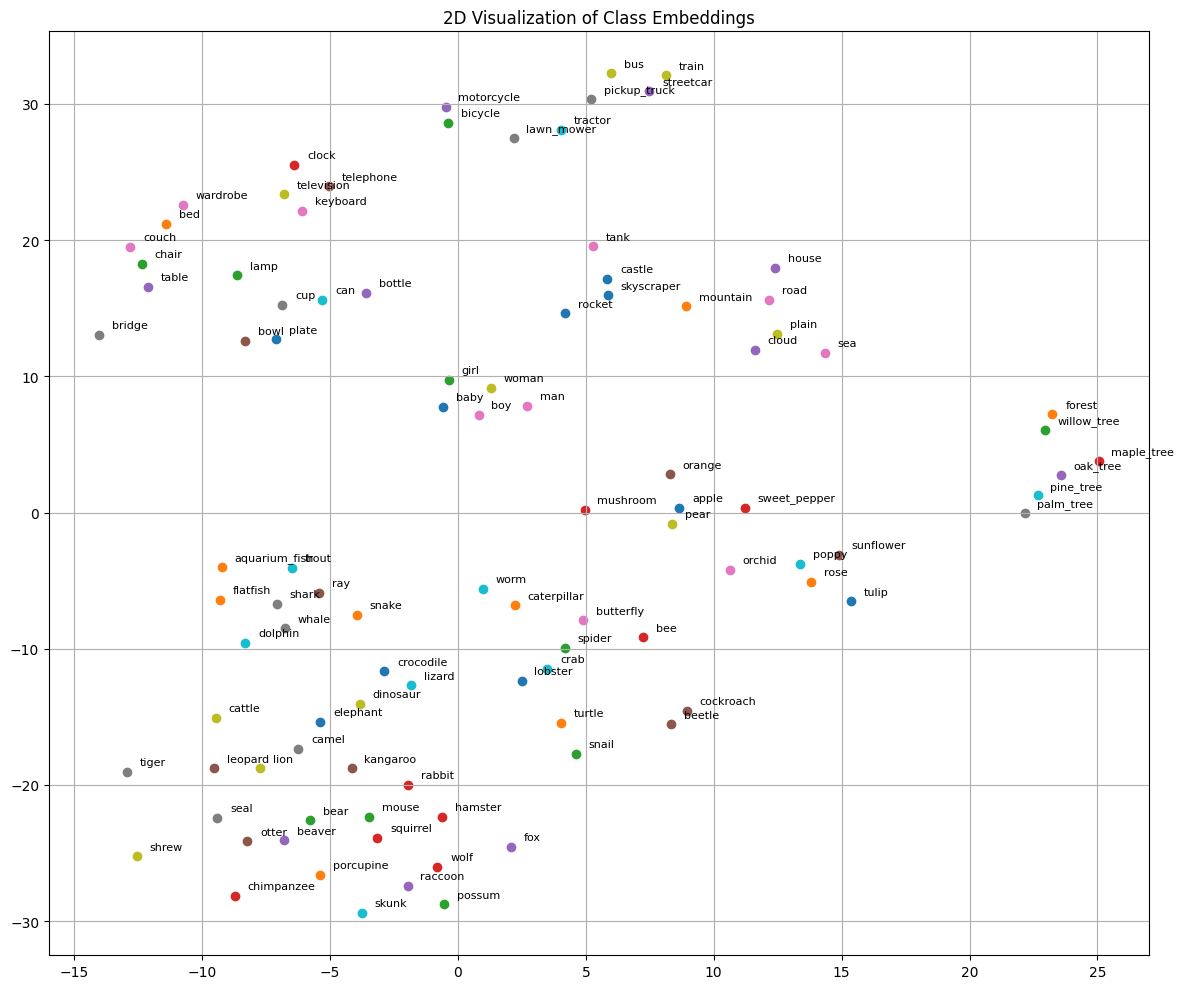

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert to matrix
embedding_matrix = torch.stack([class_encodings[name].cpu() for name in class_names]).numpy()

# Reduce dimensions to 2D
# Option 1: PCA (faster, linear)
# reducer = PCA(n_components=2)

# Option 2: t-SNE (slower, better separation)
reducer = TSNE(n_components=2, random_state=42, perplexity=10)

reduced_embeddings = reducer.fit_transform(embedding_matrix)

# Plot
plt.figure(figsize=(12, 10))
for i, label in enumerate(class_names):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.5, y + 0.5, label, fontsize=8)

plt.title("2D Visualization of Class Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
cls = 'table'

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Please write a detailed visual definition of the class {cls}. Make it more visually detailed and consistent with scientific fact for a IA model to differentiate it from this class to other classes like {set(class_names) - set([cls])}. Briefness is required, using only one paragraph."}
        ]
    }
]

try:
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    description = response.choices[0].message.content.strip()
except Exception as e:
    print(f"❌ Error with class {cls}: {e}")
    class_descriptions[cls] = None

❌ Error with class table: Object of type CLIP is not JSON serializable
